In [ ]:
import sys
import os
import time
import pandas as pd
import numpy as np
import collections

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score

In [ ]:
def classifaction_report_dataFrame(report):
    report_data = pd.DataFrame()
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        report_data = report_data.append({"class": row_data[0], "precision": float(row_data[1]), "recall": float(row_data[2]), "f1_score": float(row_data[3])}, ignore_index=True)
    return report_data

In [294]:
#split (0.8 train_data 0.2 test_data)

def prepereDataWithoutLemmatisation(split):
    data = np.empty((0))
    data_labels = np.empty((0))

    comments = pd.read_csv('FilmWeb-commentsRates.csv')
    comments = comments.reset_index()
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(comments))
    train_data = comments[:length_train_data]
    test_data = comments[length_train_data:]
  
    for index, train_data in train_data.iterrows():
        data = np.append(data, train_data['Text'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels, test_data]

In [ ]:
def prepereDataWithLemmatisation(split):
    data = np.empty((0))
    data_labels = np.empty((0))
    
    comments = pd.read_csv('FilmWeb-lemmatisation-commentsRates.csv')
    comments = comments.reset_index()
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    
    for index, comment in comments.iterrows():
        data = np.append(data, comment['comment'])
        data_labels = np.append(data_labels, comment['emotion'])
    return [data, data_labels]

In [ ]:
def SVM(iterations, dataset, is_shuffle):
    data = dataset[0]
    data_labels = dataset[1]
    report_data_Linear = pd.DataFrame()
    report_data_Liblinear = pd.DataFrame()
    report_data_Liblinear2 = pd.DataFrame()

    #Some classification problems can exhibit a large imbalance in the distribution of the target classes: 
    #for instance there could be several times more negative samples than positive samples.
    #StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately 
    #the same percentage of samples of each target class as the complete set.
    #K-krotna walidacja
    
    #shuffle - przetasowanie zbiorów
    sss = StratifiedKFold(n_splits=iterations, shuffle=is_shuffle)
    classifier_liblinear2 = svm.LinearSVC()
    for train_index, test_index in sss.split(data, data_labels):
        train_data, test_data = data[train_index], data[test_index]
        train_labels, test_labels = data_labels[train_index], data_labels[test_index]

        # Create feature vectors
        
        #min_df - When building the vocabulary ignore terms that have a document frequency strictly lower 
        #than the given threshold. This value is also called cut-off in the literature.
        #If float, the parameter represents a proportion of documents, integer absolute counts.
        #This parameter is ignored if vocabulary is not None.
        
        vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
        train_vectors = vectorizer.fit_transform(train_data)
        test_vectors = vectorizer.transform(test_data)

        # Perform classification with SVM, kernel=linear
        classifier_linear = svm.SVC(kernel='linear')
        t0 = time.time()
        classifier_linear.fit(train_vectors, train_labels)
        t1 = time.time()
        prediction_linear = classifier_linear.predict(test_vectors)
        t2 = time.time()
        time_linear_train = t1-t0
        time_linear_predict = t2-t1

        # Perform classification with SVM, kernel=linear
        classifier_liblinear = svm.LinearSVC()
        t0 = time.time()
        classifier_liblinear.fit(train_vectors, train_labels)
        t1 = time.time()
        prediction_liblinear = classifier_liblinear.predict(test_vectors)
        t2 = time.time()
        time_liblinear_train = t1-t0
        time_liblinear_predict = t2-t1
        
        # Perform classification with SVM, kernel=linear
        t0 = time.time()
        classifier_liblinear2.fit(train_vectors, train_labels)
        t1 = time.time()
        prediction_liblinear2 = classifier_liblinear.predict(test_vectors)
        t2 = time.time()
        time_liblinear_train2 = t1-t0
        time_liblinear_predict2 = t2-t1

        reportLinear = classification_report(test_labels, prediction_linear)
        reportLiblinear2 = classification_report(test_labels, prediction_liblinear2)
        
        lines = reportLinear.split('\n')
        for line in lines[2:-3]:
            row = {}
            row_data = line.split('      ')
            report_data_Linear = report_data_Linear.append({"class": row_data[0], "precision": float(row_data[1]), "recall": float(row_data[2]), "f1_score": float(row_data[3]), "support": float(row_data[4])}, ignore_index=True)

        lines = reportLiblinear.split('\n')
        for line in lines[2:-3]:
            row = {}
            row_data = line.split('      ')
            report_data_Liblinear = report_data_Liblinear.append({"class": row_data[0], "precision": float(row_data[1]), "recall": float(row_data[2]), "f1_score": float(row_data[3]), "support": float(row_data[4])}, ignore_index=True)
        
        lines = reportLiblinear2.split('\n')
        for line in lines[2:-3]:
            row = {}
            row_data = line.split('      ')
            report_data_Liblinear2 = report_data_Liblinear2.append({"class": row_data[0], "precision": float(row_data[1]), "recall": float(row_data[2]), "f1_score": float(row_data[3]), "support": float(row_data[4])}, ignore_index=True)
        
    print 'Training data:'
    counter=collections.Counter(train_labels)
    print(counter)

    print 'Test data:'
    counter=collections.Counter(test_labels)
    print(counter)
    
    return [report_data_Liblinear, report_data_Linear, report_data_Liblinear2]

In [ ]:
iterations = 10
shuffle = True

In [ ]:
#SVM without Lemmatisation
dataset = prepereDataWithoutLemmatisation()

print 'number of dataset: ' + str(iterations)
data = SVM(iterations, dataset, shuffle)
print 'Linear report:'
printReportLinear(data)
print 'Liblinear report:'
printReportLiblinear(data)

In [ ]:
#SVM with Lemmatisation
dataset = prepereDataWithLemmatisation()

print 'number of dataset: ' + str(iterations)
data = SVM(iterations, dataset, shuffle)
print 'Linear report:'
printReportLinear(data)
print 'Liblinear report:'
printReportLiblinear(data)

print 'Liblinear2 report:'
printReportLiblinear2(data)

In [ ]:
def printReportLiblinear(dataframe):
    liblinear = dataframe[1]
    for index, data in liblinear.groupby('class'):
        print(data)
        
def printReportLiblinear2(dataframe):
    liblinear = dataframe[2]
    for index, data in liblinear.groupby('class'):
        print(data)

In [ ]:
def printReportLinear(dataframe):
    linear = dataframe[0]
    for index, data in linear.groupby('class'):
        print(data)

In [289]:
def SVM_liblinear(iterations, dataset, is_shuffle):
    data = dataset[0]
    data_labels = dataset[1]
    
    sss = StratifiedKFold(n_splits=iterations, shuffle=is_shuffle)

    for train_index, test_index in sss.split(data, data_labels):
        train_data = data[train_index]
        train_labels = data_labels[train_index]
        
        vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
        train_vectors = vectorizer.fit_transform(train_data)
        
        classifier_liblinear = svm.LinearSVC()
        classifier_liblinear.fit(train_vectors, train_labels)
        
    return [classifier_liblinear,vectorizer]

In [295]:
#testing dataset

iterations = 10
shuffle = True
dataset = prepereDataWithoutLemmatisation(0.8)
[classifier, vectorizer] = SVM_liblinear(iterations, dataset, shuffle)
testData = dataset[2]
detectedEmotion = SCV_detectingEmotions(classifier,vectorizer,testData['Text'])

result_df = pd.DataFrame({"text": testData['Text'], "detectedEmotion": detectedEmotion, 'emotion': testData['emotion']})

In [250]:
def prepereTestData(maximumNegativeRate, mimimumPositiveRate, ):
    comments = pd.read_csv('FilmWeb-commentsRates.csv')
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    comments = comments[(comments.rate <= maximumNegativeRate) | (comments.rate >= mimimumPositiveRate)]
    comments = comments.reset_index()
    #charToRemove= dict.fromkeys('!@#$?.:,')
   # comments['Text'] = comments['Text'].translate(charToRemove)
    return comments

In [259]:
def SCV_detectingEmotions(classifier, vectorizer, test_data):
    test_vectors = vectorizer.transform(test_data)
    prediction_liblinear = classifier.predict(test_vectors)
    return prediction_liblinear

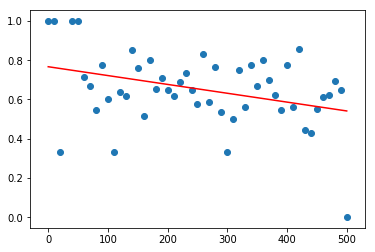

In [296]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_length(text):
    return len(text)

def get_length_bin(length):
    return length / 10

def get_score(result):
    return 1 if result else 0

result_df['correct_guess'] = result_df['detectedEmotion'] == result_df['emotion']
result_df['score'] = map(get_score, result_df['correct_guess'])
result_df['text_length'] = map(get_length, result_df['text'])
result_df['text_length_bin'] = map(get_length_bin, result_df['text_length'])
grouped = result_df.groupby('text_length_bin', as_index=False)['score'].mean()

fig, ax = plt.subplots()
x = grouped.text_length_bin * 10
y = grouped.score
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)

fig.show()

In [297]:
print 'Number of correct guess: ' + str(len(result_df.loc[result_df['correct_guess'] == True]))
print 'Number of wrong guess: ' + str(len(result_df.loc[result_df['correct_guess'] == False]))

Number of correct guess: 578
Number of wrong guess: 313


In [281]:
df1 = result_df.head(100)

In [287]:
first_ten

,detectedEmotion,emotion,text,correct_guess,score,text_length,text_length_bin
0,negative,negative,"""Boże, zaraz się zrzygam"".. ...",True,1,479,47
1,negative,negative,"Film dla ""ajfonowych"" lemingów z ujemnym IQ. ...",True,1,307,30
2,negative,negative,To najbardziej antyfeministyczna rzecz w dziej...,True,1,473,47
3,negative,negative,Prawdziwy dramat Na wst...,True,1,462,46
4,negative,negative,Film Za mało Złotych M...,True,1,68,6
5,negative,negative,Hmm... budżet: 40 000 000 $ ...,True,1,163,16
6,negative,negative,Połączenie komedii romantycznej z soft porno. ...,True,1,466,46
7,negative,negative,Chciałabym odzobaczyć f...,True,1,360,36
8,negative,negative,"""Boże, zaraz się zrzygam""..Słowa Koroniewskiej...",True,1,442,44
9,negative,negative,"Film dla ""ajfonowych"" lemingów z ujemnym IQ.Te...",True,1,269,26


In [302]:
def createCommentsWithLemmatisation():
    commentsWithLemmatisation = pd.DataFrame()
    comments = pd.read_csv('FilmWeb-commentsRates.csv')
    for comment in comments:
        print(comment)
        #text = lemmatisation(comment['Text'])
        #commentsWithLemmatisation = commentsWithLemmatisation.append({'text': ''.join(text), 'emotion': comment['emotion'], 'rate': comment['rate']}, ignore_index=True)
    #return commentsWithLemmatisation

In [303]:
createCommentsWithLemmatisation()

Text
emotion
rate
